In [17]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import *
from pylab import *

import seaborn as sns # poista?
from scipy import stats as sts # zipf, linreg, powerlaw
from scipy.stats import t
from scipy.optimize import curve_fit
# from scipy.special import zetac

### Resources:
1. https://www.nltk.org/book/
2. Draw Zipf plot: https://finnaarupnielsen.wordpress.com/2013/10/22/zipf-plot-for-word-counts-in-brown-corpus/
3. Zipf plot Python 3: https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
4. Estimate alpha: http://www-personal.umich.edu/~mejn/courses/2006/cmplxsys899/powerlaws.pdf (also, https://arxiv.org/pdf/0706.1062.pdf pages 6, 36,)
5. Powerlaw package: https://arxiv.org/pdf/1305.0215.pdf

Read data, tokenize and calculate frequencies and ranks.

*TO-DO: tokenization paremmin*

In [50]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

# Read data and save books to dict
for f in files:
    file = open(f, "r", encoding='utf-8')
    book = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(book)
    file.close()

books = {files[0]: books[0], files[1]: books[1], files[2]: books[2]}

# Tokenize and count frequencies
tokens = {}
counts = {}
ranks = {}
freqs = {}
#indices = {}

for b in books:
    tokens_w_count = Counter(map(str.lower, books[b]))
    tokens[b] = sorted([k for k in tokens_w_count.keys()])
    counts[b] = np.array([tokens_w_count[k] for k in tokens[b]])
    ranks[b] = np.arange(1, len(counts[b]) + 1)
    indices = np.argsort(-counts[b])
    freqs[b] = counts[b][indices]


### Task 1.

Use appropriate NLTK coding (you can inspire from coding examples of the online NLTK book) in order to **plot the histogram of the twenty most frequent words** in each of the three ebooks. **Comment on the nature of these words** in terms of their relevance to the content of the ebook. Suggest your own approach to evaluate such relevancy.  

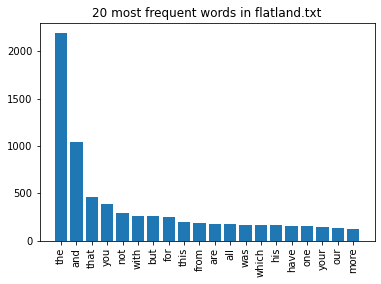

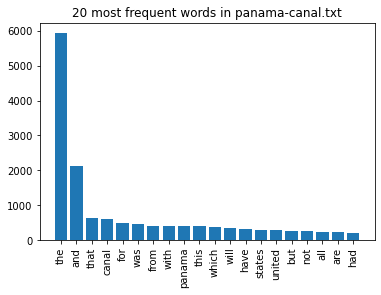

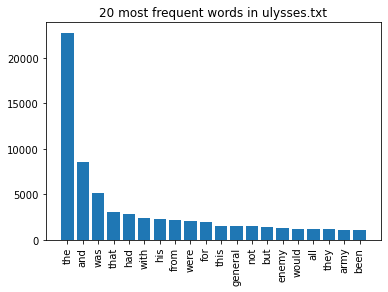

In [51]:
for b in books:
    df = pd.DataFrame({'word': tokens[b], 'count': counts[b]}).sort_values(by=['count'], ascending=False).head(20)
    #df = df.sort_values(by=['count']) # ascending for plot

    x = list(df.loc[:, 'word'])
    y = list(df.loc[:, 'count'])
    
    title("20 most frequent words in " + b)
    plt.bar(x, y)
    plt.xticks(rotation='vertical')
    plt.show() 

**Comment on the nature of these words in terms of their relevance to the content of the ebook:**
- Kussakin kirjassa enimmäkseen stopwordeja/epärelevantteja semantiikan näkökulmasta
- Sisältö/konteksti tulee varmaan parhaiten selville panaman kanaalista kertovan kirjan kohdalla, flatlandin sisällöstä ei näiden perusteella saa paljoa selville


**Suggest your own approach to evaluate such relevancy:**
- Alkajaisiksi stopwordit pois ja sitten vastaava listaus frekvenssijärjestyksessä
- muita ideoita?

### Task 2 & 3.
2. Use the frequency of the words to fit the Zipf distribution for each ebook. Draw the zipf fitting cure for each ebook and comment on the goodness of fit.


3. We would like to **quantify the goodness of fit of the Zipf law** using the statistical confidence bound at 90% confidence. Ideally, we should obtain an upper curve and a lower curve around the Zipf law cure. If the fitting is statistically valid at 90% confidence, then all points should be located within this upper and lower curve. Test different values of the confidence value, e.g., 80%, 85%, 90% and 95% and report the number of points that fall outside the upper and lower bounds for each case.


#### Draw Zipf plots (log-log)

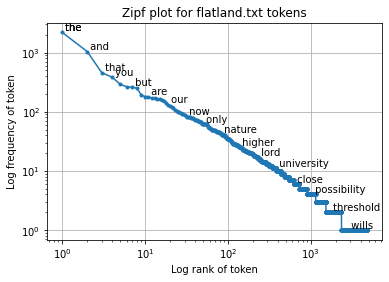

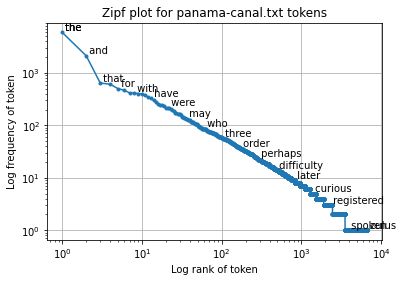

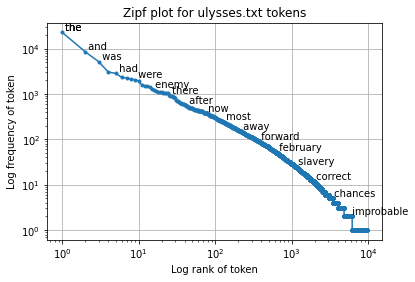

In [52]:
for b in books:
    indices = np.argsort(-counts[b])
    
    loglog(ranks[b], freqs[b], marker=".")
    title("Zipf plot for " + b + " tokens")
    xlabel("Log rank of token")
    ylabel("Log frequency of token")
    grid(True)
    for n in list(logspace(-0.5, log10(len(counts[b])), 20).astype(int)):
        # Not all words fit on x-axis; using try-except to break out of loop
        try:
            dummy = text(ranks[b][n], freqs[b][n], " " + tokens[b][indices[n]], 
                         verticalalignment = "bottom", horizontalalignment = "left")
        except IndexError:
            break
    show()

#### Fit Zipf curve

Zipf distribution: $f(r) \sim r^{-\alpha}$, $\alpha \approx 1$ 

(Kurssikirja: $\alpha = 1$)

*Although there is no exact closed-form expression for $\hat{\alpha}$ in the discrete case, an approximate expression can be derived. --* (Source: https://wiki.santafe.edu/images/6/66/CSN_07_PowerlawDistributionsInEmpiricalData_arxiv.pdf , pg. 5)

Approximate ML estimator for shape parameter $\alpha$ in discrete data:

> $ \hat{\alpha} = 1 + n\left( \sum_{i=1}^n ln \frac{x_i}{x_{min} - \frac{1}{2}} \right)^{-1} $

In [6]:
def ahat(n, rank):
    return 1 + ( n / sum(log(rank / min(rank) - 0.5) ))

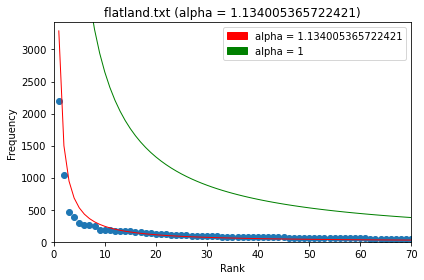

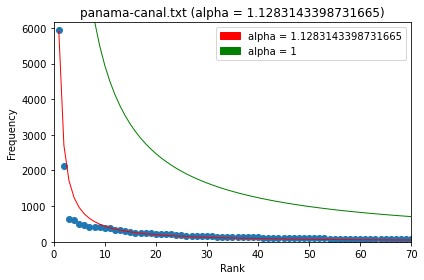

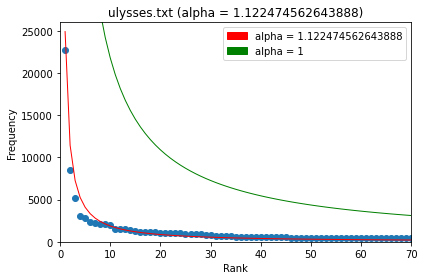

In [57]:
def zipfcurve():
    for b in books:
        # Estimate alpha
        alpha = ahat(len(ranks[b]), ranks[b])
        
        # Zipf pmf
        p = sts.zipf.pmf(ranks[b], alpha)
    
        # Fit curve
        total = sum([freqs[b]])
        plt.title(str(b) + " (alpha = " + str(alpha) + ")")
        plt.scatter(ranks[b], freqs[b])
        plt.plot(ranks[b], (1 / ranks[b]) * total, lw=1, color='green')
        plt.plot(ranks[b], p * total, lw=1, color='red')
        plt.ylabel("Frequency")
        plt.xlabel("Rank")
        plt.xlim(0, 70) # limit y and x-axis to better see the fit
        plt.ylim(0, max(p * total + 0.005 * total)) 
        plt.tight_layout()
        red_patch = matplotlib.patches.Patch(color='red', label='alpha = ' + str(alpha))
        green_patch = matplotlib.patches.Patch(color='green', label='alpha = 1')
        plt.legend(handles=[red_patch, green_patch])
        plt.show()

zipfcurve()

#### Fit linear regression

Sovitin kirjojen dataan lineaarisen regressiomallin ja laskin ja piirsin sovitteiden luottamusvälit ja ennustevälit.
Luottamusvälit erottuu kuvista sovitteen ympäriltä kun kuvaan zoomaa käyrän kohdalta.

- Luottamusvälit näyttäisi ainakin näin laskettuna jäävän melko kapeiksi, niin että sinne ei osu juuri yhtään pisteitä. (Tyyliin 100-200 per 4000-9000).
- Kuitenkin tuon 3-kohdan tehtävänannon perusteella tuntuisi että halutulle luottamusvälille osuisi suurehko osa pisteistä.
- Ennustevälit olisi leveämpiä, mutta niitä ei kai varsinaisesti kysytty. 
- Toinen vaihtoehto olisi sovittaa jokin muu malli, mutta tuo tehtävänannon vihje spacy.stats.linregress -paketista viittaisi mun mielestä nimenomaan lineaariseen malliin. 

Olisko teillä jotain muuta tulkintaa tuosta tehtävänannosta?

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


regular:  ['the', 'and', 'that', 'you', 'not', 'with', 'but', 'for', 'this', 'from', 'are', 'all', 'was', 'which', 'his', 'have', 'one', 'your', 'our', 'more']
regular:  ['the', 'and', 'was', 'that', 'had', 'with', 'his', 'from', 'were', 'for', 'this', 'general', 'not', 'but', 'enemy', 'would', 'all', 'they', 'army', 'been']
regular:  ['the', 'and', 'that', 'canal', 'for', 'was', 'from', 'with', 'panama', 'this', 'which', 'will', 'have', 'states', 'united', 'but', 'not', 'all', 'are', 'had']
[0.80, 0.85, 0.90, 0.95], (length)
Unfiltered: flatland.txt : [84, 100, 112, 135], (4733)
Filtered:   flatland.txt : [82, 94, 108, 127], (4636)
Unfiltered: ulysses.txt : [125, 141, 157, 189], (9556)
Filtered:   ulysses.txt : [144, 161, 186, 220], (9453)
Unfiltered: panama-canal.txt : [102, 114, 130, 154], (6590)
Filtered:   panama-canal.txt : [81, 91, 104, 123], (6495)


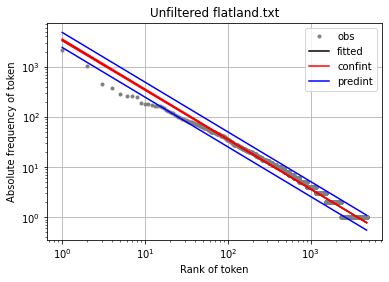

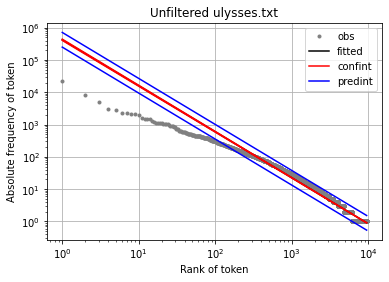

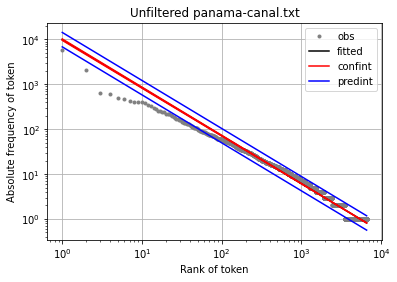

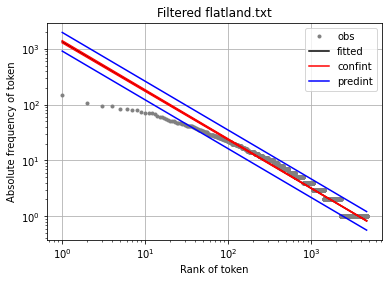

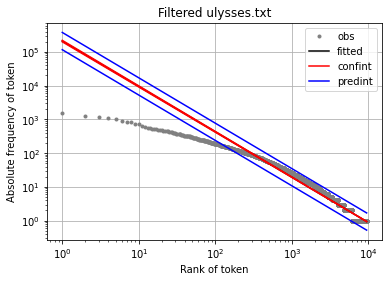

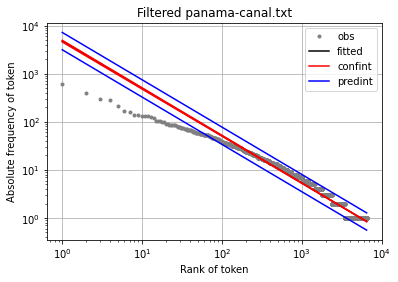

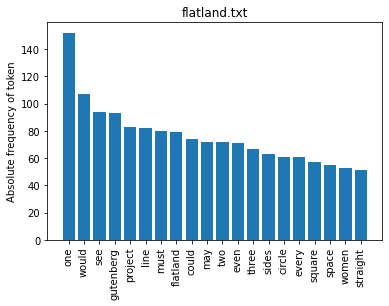

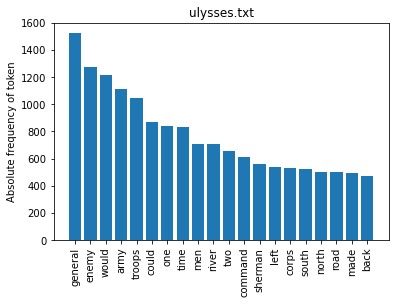

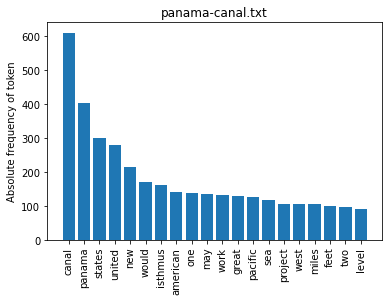

In [70]:
# Eetun koodi

from __future__ import division
import sys
from itertools import *
from pylab import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy import stats
from scipy.stats import t, zipf
from scipy.optimize import curve_fit
from scipy.special import zetac

nltk.download('stopwords')

def main():
    confidence_levels = [0.8, 0.85, 0.9, 0.95]

    bookname1 = 'flatland.txt'
    bookname2 = 'ulysses.txt'
    bookname3 = 'panama-canal.txt'

    # The preambles and postambles added by Gutenberg have been removed from the .txt files

    book1 = pick_book(bookname1)
    book2 = pick_book(bookname2)
    book3 = pick_book(bookname3)

    tokens_with_count1 = tokenizer(book1)
    tokens_with_count2 = tokenizer(book2)
    tokens_with_count3 = tokenizer(book3)
    ranks1, indices1, frequencies1 = token_counter(tokens_with_count1)
    ranks2, indices2, frequencies2 = token_counter(tokens_with_count2)
    ranks3, indices3, frequencies3 = token_counter(tokens_with_count3)
    fitted_value1, lower_bound_fit1, upper_bound_fit1, upper_bound_pred1, lower_bound_pred1, r_squared1, new_r1, ci_level1 = linreg(ranks1, frequencies1, 0.975)
    fitted_value2, lower_bound_fit2, upper_bound_fit2, upper_bound_pred2, lower_bound_pred2, r_squared2, new_r2, ci_level2 = linreg(ranks2, frequencies2, 0.975)
    fitted_value3, lower_bound_fit3, upper_bound_fit3, upper_bound_pred3, lower_bound_pred3, r_squared3, new_r3, ci_level3 = linreg(ranks3, frequencies3, 0.975)

    filtered_words1, ftokens_with_count1, topwords1, doclen1 = sw_filter(book1)
    filtered_words2, ftokens_with_count2, topwords2, doclen2 = sw_filter(book2)
    filtered_words3, ftokens_with_count3, topwords3, doclen3 = sw_filter(book3)
    ranks1f, indices1f, frequencies1f = token_counter(ftokens_with_count1)
    ranks2f, indices2f, frequencies2f = token_counter(ftokens_with_count2)
    ranks3f, indices3f, frequencies3f = token_counter(ftokens_with_count3)
    fitted_value1f, lower_bound_fit1f, upper_bound_fit1f, upper_bound_pred1f, lower_bound_pred1f, r_squared1f, new_r1f, ci_level1f = linreg(ranks1f, frequencies1f, 0.975)
    fitted_value2f, lower_bound_fit2f, upper_bound_fit2f, upper_bound_pred2f, lower_bound_pred2f, r_squared2f, new_r2f, ci_level2f = linreg(ranks2f, frequencies2f, 0.975)
    fitted_value3f, lower_bound_fit3f, upper_bound_fit3f, upper_bound_pred3f, lower_bound_pred3f, r_squared3f, new_r3f, ci_level3f = linreg(ranks3f, frequencies3f, 0.975)

    # zipf_pmf(ranks1,frequencies1,0.975)

    print("[0.80, 0.85, 0.90, 0.95], (length)")
    print_point_count(bookname1, ranks1, frequencies1, confidence_levels,0)
    print_point_count(bookname1, ranks1f, frequencies1f, confidence_levels,1)
    print_point_count(bookname2, ranks2, frequencies2, confidence_levels,0)
    print_point_count(bookname2, ranks2f, frequencies2f, confidence_levels,1)
    print_point_count(bookname3, ranks3, frequencies3, confidence_levels,0)
    print_point_count(bookname3, ranks3f, frequencies3f, confidence_levels,1)


    #print(bookname1, topwords1)
    #print(bookname2, topwords2)
    #print(bookname3, topwords3)

    zipf_plot(bookname1, ranks1, frequencies1, fitted_value1, upper_bound_fit1, lower_bound_fit1, upper_bound_pred1, lower_bound_pred1,0) #, ftokens_with_count1)
    zipf_plot(bookname2, ranks2, frequencies2, fitted_value2, upper_bound_fit2, lower_bound_fit2, upper_bound_pred2, lower_bound_pred2,0) #, ftokens_with_count2)
    zipf_plot(bookname3, ranks3, frequencies3, fitted_value3, upper_bound_fit3, lower_bound_fit3, upper_bound_pred3, lower_bound_pred3,0) #, ftokens_with_count3)

    zipf_plot(bookname1, ranks1f, frequencies1f, fitted_value1f, upper_bound_fit1f, lower_bound_fit1f, upper_bound_pred1f, lower_bound_pred1f,1)
    zipf_plot(bookname2, ranks2f, frequencies2f, fitted_value2f, upper_bound_fit2f, lower_bound_fit2f, upper_bound_pred2f, lower_bound_pred2f,1)
    zipf_plot(bookname3, ranks3f, frequencies3f, fitted_value3f, upper_bound_fit3f, lower_bound_fit3f, upper_bound_pred3f, lower_bound_pred3f,1)

    hist_plot(ftokens_with_count1,bookname1)
    hist_plot(ftokens_with_count2,bookname2)
    hist_plot(ftokens_with_count3,bookname3)

def pick_book(filename):
    # Read the file and save the words, stripping punctuation, numbers and such
    open_file = open(filename, 'r', encoding='utf-8')
    file_to_string = open_file.read()
    book_words = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file_to_string)
    return book_words


def sw_filter(book_words):
    stop_words = stopwords.words('english')
    stop_words.append('The')
    filtered_words = [w.lower() for w in book_words if not w.lower() in stop_words]
    ftokens_with_count = Counter(map(str.lower, filtered_words))
    topwords = [t[0] for t in ftokens_with_count.most_common(20)]
    doclen = len(ftokens_with_count)
    return filtered_words, ftokens_with_count, topwords, doclen


def tokenizer(book_words):
    # https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
    tokens_with_count = Counter(map(str.lower, book_words))
    topwords = [t[0] for t in tokens_with_count.most_common(20)]
    print("regular: ", topwords)
    return tokens_with_count


def token_counter(tokens_with_count):
    tokens = sorted([k for k in tokens_with_count.keys()])
    counts = array([tokens_with_count[k] for k in tokens])
    ranks = arange(1, len(counts) + 1)
    indices = argsort(-counts)
    frequencies = counts[indices]
    return ranks, indices, frequencies


# 3 - Linear regression
def linreg(ranks, frequencies, ci_level):
    r = log(ranks)
    fr = log(frequencies)

    slope, intercept, r_value, p_value, std_err = stats.linregress(r, fr)
    r_squared = r_value ** 2
    # print("For the full data, we get the following linear regression")
    # print("slope:     %f    intercept: %f" % (slope, intercept))
    # print("r_value:   %f    p_value: %f" % (r_value, p_value))
    # print("std_error: %f" % std_err)

    obs_values = fr
    fitted_value = slope * r + intercept
    residuals = obs_values - fitted_value

    n = len(fr)
    sse = sum(residuals ** 2)
    mse = sse / (n - 2)
    t_val = t.ppf(ci_level, n - 2)  # Student's t-distribution with n-2 df.
    S = sqrt(mse)
    SSX = sum((r - mean(r)) ** 2)

    SE_fit = S * sqrt(1 / n + (r - mean(r)) ** 2 / SSX)  # Standard error for the fitted values
    upper_bound_fit = fitted_value + t_val * SE_fit  # Upper confidence interval bound at given confidence level
    lower_bound_fit = fitted_value - t_val * SE_fit  # Lower confidence interval bound at given confidence level

    new_r = arange(min(r), max(r) + 1, 1)  # New data for calculating predicted values
    predicted_values = mean(fr) + slope * (r - mean(r))  # Calculate predicted values for the new data
    SE_pred = S * sqrt(1 + 1 / n + (r - mean(r)) ** 2 / SSX)  # Standard error for predicted values
    upper_bound_pred = predicted_values + t_val * SE_pred  # Confidence bounds for predicted values
    lower_bound_pred = predicted_values - t_val * SE_pred

    return fitted_value, lower_bound_fit, upper_bound_fit, upper_bound_pred, lower_bound_pred, r_squared, new_r, ci_level


def point_count(ranks, frequencies, lower_bound, upper_bound):
    point_count = 0
    exlow = exp(lower_bound)
    exup = exp(upper_bound)

    for i in ranks[1:len(ranks)-1]:
        if exlow[i] < frequencies[i] < exup[i]:
            point_count += 1
    return point_count


def print_point_count(bookname, ranks, frequencies, confidence_levels,f_ind):
    book1_wordcount = []
    for level in confidence_levels:
        alpha = 1 - (1 - level) / 2
        reg_vals = linreg(ranks, frequencies, alpha)
        wordcount = point_count(ranks, frequencies, reg_vals[1], reg_vals[2])
        book1_wordcount.append(wordcount)
    if f_ind == 1:
        print("Filtered:   {} : {}, ({})".format(bookname, book1_wordcount, len(ranks)))
    if f_ind == 0:
        print("Unfiltered: {} : {}, ({})".format(bookname, book1_wordcount, len(ranks)))


def zipf_plot(bookname, ranks, frequencies, fitted_value, upper_bound_fit, lower_bound_fit, upper_bound_pred, lower_bound_pred,f_ind): #, filtered_words_with_count):
    fig, (ax1) = subplots(1, 1)
    ax1.loglog(ranks, frequencies, '.',     color='grey', label='obs')
    ax1.plot(ranks, exp(fitted_value),      color='black', label='fitted')
    ax1.plot(ranks, exp(upper_bound_fit),   color='red', label='confint')   # Luottamusväli
    ax1.plot(ranks, exp(lower_bound_fit),   color='red')                    # Luottamusväli
    ax1.plot(ranks, exp(upper_bound_pred),  color='blue', label='predint')  # Ennusteväli
    ax1.plot(ranks, exp(lower_bound_pred),  color='blue')                   # Ennusteväli
    ax1.set_ylabel("Absolute frequency of token")
    ax1.set_xlabel("Rank of token")
    ax1.legend()
    ax1.grid(True)
    if f_ind == 1:
        ax1.set_title("Filtered {}".format(bookname))
    else:
        ax1.set_title("Unfiltered {}".format(bookname))
    show()

def hist_plot(filtered_words_with_count,bookname):
    topword_count = [t[1] for t in filtered_words_with_count.most_common(20)]
    topwords = [t[0] for t in filtered_words_with_count.most_common(20)]

    x = arange(1,21)
    fig, ax = subplots(1,1)
    ax.bar(x=x, height=topword_count)
    ax.set_xticks(x)
    ax.set_xticklabels(topwords, rotation='vertical')
    ax.set_title(bookname)
    ax.set_ylabel("Absolute frequency of token")
    show()

main()

### Task 6.

We would like to fit the power-law with exponential cutoff instead of standard zipf distribution. Repeat 2) and 3) and compare the fitting of the Zipf law to that of power-law with exponential cutoff for each of the two ebooks.

#### Power law with exponential cutoff

> $f(x) \propto x^{\alpha}e^{\beta x} $ 

(Lectures: $p(x) \sim x^{-\alpha}e^{-x/\kappa}$)


In [64]:
def expcutoff(x, alpha, beta):
    return x**-alpha * exp(-beta * x)

In [68]:
p = curve_fit(expcutoff, ranks["flatland.txt"], freqs["flatland.txt"])
p[0]

[-3.5452739   0.28277033]
[[ 0.00795456 -0.00134645]
 [-0.00134645  0.0002379 ]]


<ipython-input-64-0e4e4b296964>:2: RuntimeWarning: overflow encountered in power
  return x**-alpha * exp(-beta * x)
<ipython-input-64-0e4e4b296964>:2: RuntimeWarning: overflow encountered in exp
  return x**-alpha * exp(-beta * x)
<ipython-input-64-0e4e4b296964>:2: RuntimeWarning: overflow encountered in multiply
  return x**-alpha * exp(-beta * x)


In [69]:
# sts.powerlaw.fit(freqs["flatland.txt"])

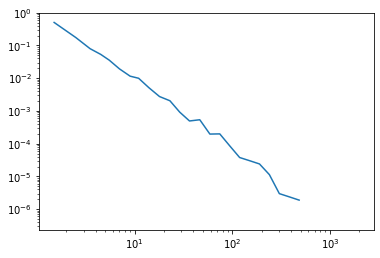

In [125]:
powerlaw.plot_pdf(freqs["flatland.txt"])